In [31]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS, CartesianRepresentation, match_coordinates_sky
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle

In [32]:
def match_box_id(points_x, points_y, bins_x, bins_y):
    # bins_x_id and bins_y_id
    bins_x_id = np.digitize(points_x, bins_x) - 1
    bins_y_id = np.digitize(points_y, bins_y) - 1

    return bins_x_id, bins_y_id


def cal_distort_model(dis_res_xy_list, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y):

    for points_inf in dis_res_xy_list:
        points_x = points_inf[0, :]
        points_y = points_inf[1, :]
        distort_value_x = points_inf[2, :]
        distort_value_y = points_inf[3, :]

        bins_x_id, bins_y_id = match_box_id(points_x, points_y, bins_x, bins_y)

        distort_bins, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)))
        distort_values_x, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_x)
        distort_values_y, _, _ = np.histogram2d(bins_x_id, bins_y_id, bins=(range(bins_num + 1), range(bins_num + 1)),
                                                weights=distort_value_y)

        distort_sum_bins += distort_bins
        distort_sum_values_x += distort_values_x
        distort_sum_values_y += distort_values_y

    return distort_sum_bins, distort_sum_values_x, distort_sum_values_y

def sigma_filter(data, data_rel, sigma_scale):

    mean_data = np.mean(data)
    std_data = np.std(data)
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    filter = (mean_data - sigma_scale * std_data < data) & (mean_data + sigma_scale * std_data > data)

    data_filter = data[filter]
    data_rel_filter = data_rel[filter]

    return data_filter, data_rel_filter

# match_res_cross = []

# for i in range(len(match_C1_01_res)):
#     temp_xy = match_C1_01_res.iloc[i, 0:2]
#     temp_mag = match_C1_01_res.iloc[i, 4]
#     add_mag = match_C1_01_res.iloc[i, 5]

#     index_xy = np.sum(np.abs(match_C2_01_res.iloc[:, 0:2] - temp_xy) < 2, axis=1) == 2
#     index_mag = index_mag = np.abs(match_C2_01_res.iloc[:, 4] - temp_mag) < 1e-8
#     index = index_xy & index_mag
#     if np.sum(index) == 1:
#         match_res_cross.append(np.hstack((np.array(match_C2_01_res[index])[0], add_mag)))

# match_res_cross = np.array(match_res_cross)


def match_cross(match_be_mod, match_to_mod):
    match_res_cross = []

    match_be = match_be_mod
    match_to = match_to_mod

    for i in range(len(match_to)):
        temp_xy = match_to.iloc[i, 0:2]
        temp_mag = match_to.iloc[i, 4]
        add_mag = match_to.iloc[i, 5]

        index_xy = np.sum(np.abs(match_be.iloc[:, 0:2] - temp_xy) < 2, axis=1) == 2
        index_mag = index_mag = np.abs(match_be.iloc[:, 4] - temp_mag) < 1e-8
        index = index_xy & index_mag
        if np.sum(index) == 1:
            match_res_cross.append(np.hstack((np.array(match_be[index])[0], add_mag)))

    match_res_cross = np.array(match_res_cross)
    return match_res_cross

In [33]:
with open('match_res/match_C1_01_res.pkl', 'rb') as f:
    match_C1_01_res = pickle.load(f)

with open('match_res/match_C2_01_res.pkl', 'rb') as f:
    match_C2_01_res = pickle.load(f)

with open('match_res/match_C3_01_res.pkl', 'rb') as f:
    match_C3_01_res = pickle.load(f)

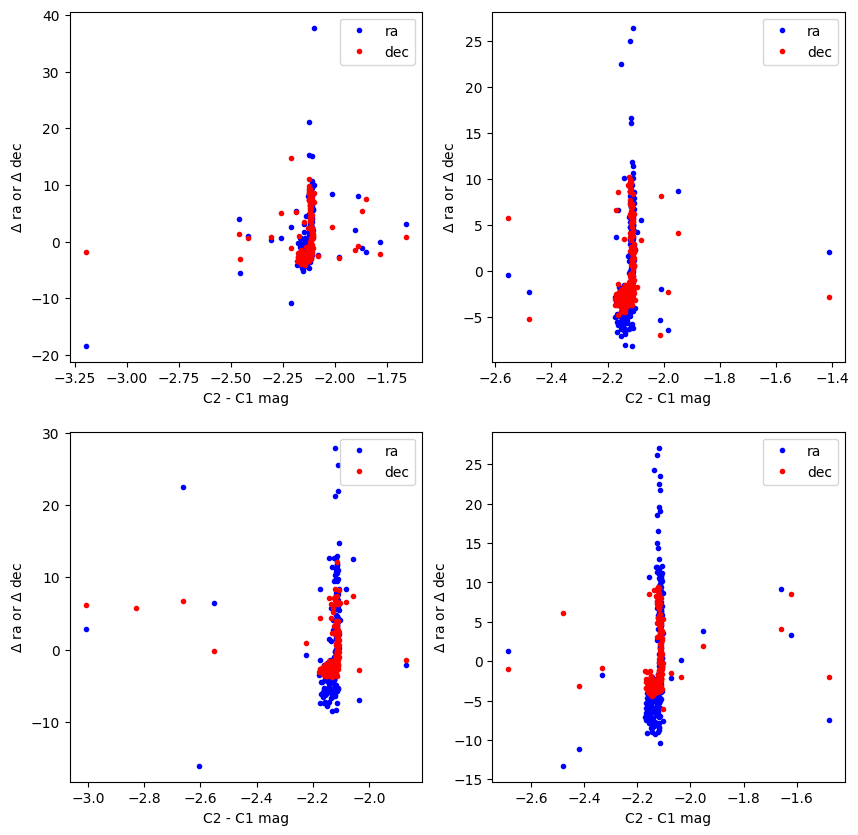

In [34]:
match_res_cross = match_cross(match_C2_01_res, match_C1_01_res)

match_x, match_y, dis_ra, dis_dec = [match_res_cross[:, i] for i in range(4)]
match_mag_color = match_res_cross[:, 5] - match_res_cross[:, 6]

# create bins
bins_num = 2
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_color[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)
        axes[i][j].plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
        axes[i][j].plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
        axes[i][j].set_xlabel("C2 - C1 mag")
        axes[i][j].set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axes[i][j].legend()

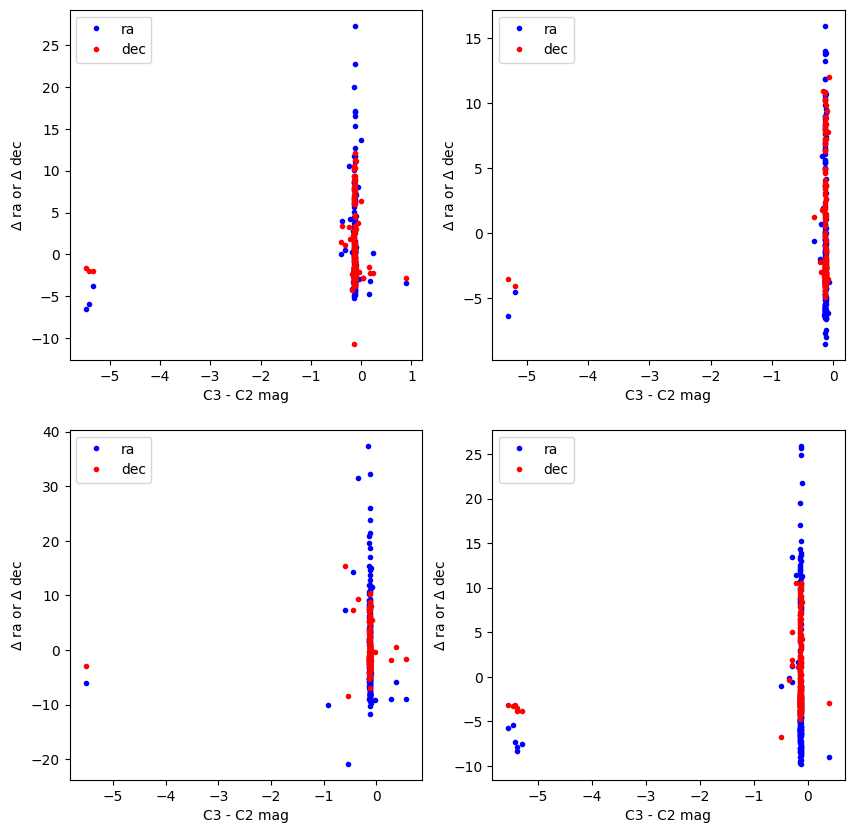

In [35]:
match_res_cross = match_cross(match_C3_01_res, match_C2_01_res)

match_x, match_y, dis_ra, dis_dec = [match_res_cross[:, i] for i in range(4)]
match_mag_color = match_res_cross[:, 5] - match_res_cross[:, 6]

# create bins
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_color[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)
        axes[i][j].plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
        axes[i][j].plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
        axes[i][j].set_xlabel("C3 - C2 mag")
        axes[i][j].set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axes[i][j].legend()

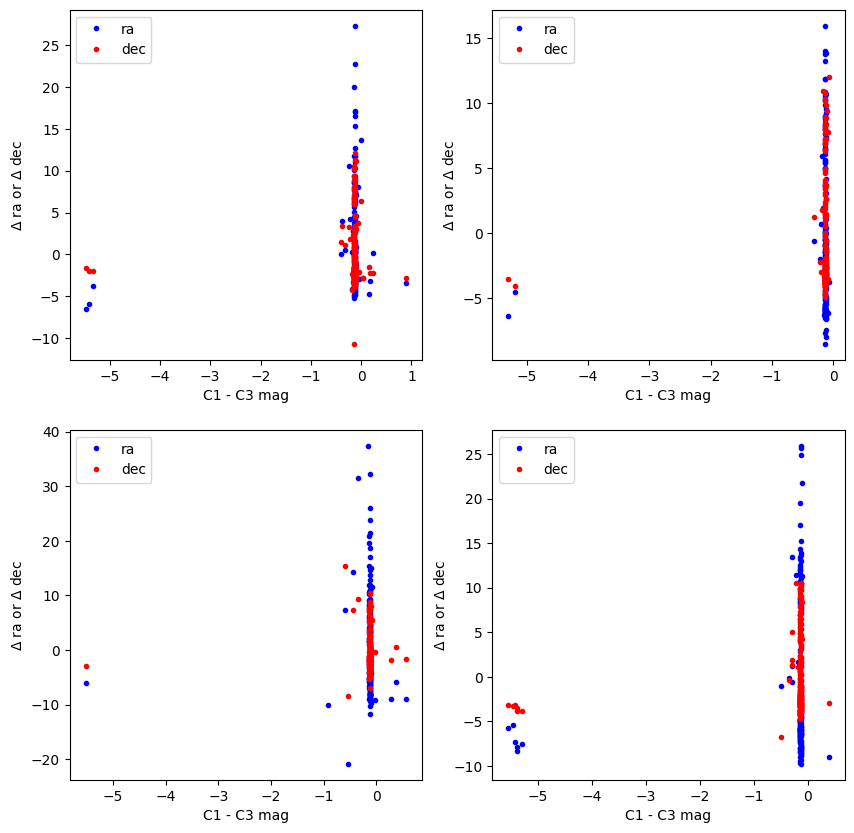

In [36]:
match_res_cross = match_cross(match_C3_01_res, match_C2_01_res)

match_x, match_y, dis_ra, dis_dec = [match_res_cross[:, i] for i in range(4)]
match_mag_color = match_res_cross[:, 5] - match_res_cross[:, 6]

# create bins
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = match_box_id(match_x, match_y, bins_x, bins_y)

dict_mag_dis = {}
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        dict_mag_dis.update({str(i)+str(j): []})
        index = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag_color[index]
        match_x_box = match_x[index]
        match_y_box = match_y[index]
        dis_ra_box = dis_ra[index]
        dis_dec_box = dis_dec[index]
        dis_ra_box, match_mag_ra_box = sigma_filter(dis_ra_box, match_mag_box, 3)
        dis_dec_box, match_mag_dec_box = sigma_filter(dis_dec_box, match_mag_box, 3)
        axes[i][j].plot(match_mag_ra_box, dis_ra_box, '.', c='blue', label="ra")
        axes[i][j].plot(match_mag_dec_box, dis_dec_box, '.', c='red', label="dec")
        axes[i][j].set_xlabel("C1 - C3 mag")
        axes[i][j].set_ylabel(r"$\Delta$ ra or $\Delta$ dec")
        axes[i][j].legend()